# Speech Commands Recognition (Keyword Spotting)

In [1]:
import os
import pathlib
import types

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from scipy.io import wavfile

plt.rcParams['font.size'] = '12'
# %matplotlib inline


To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [2]:
# uncomment to install python_speech_features
# ! pip install python_speech_features

In [3]:
import python_speech_features

## 1 - Data loading and preprocessing
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [4]:
choose_dataset = 2  # 1 for mini, 2 for full

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = commands[mask]
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [6]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else create it and store the dataframe as a .txt file; creating the pd object can take some time
else:
    reference_df_train = pd.DataFrame(columns=['label', 'file'])
    for i, command in enumerate(commands):
        print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
        for file in all_files[command]:
            if file in reference_df_val['file'].values:
                continue
            if file in reference_df_test['file'].values:
                continue
            
            reference_df_train.loc[len(reference_df_train)] = [command, file]
              
    print('Done!')
    print('\n')
    
    # store reference_df_train in .txt file
    reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
print('----------------------------')
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

There are 105829 audio files in the dataset
----------------------------
TRAINING FILES:
          label                   file
0      backward  0165e0e8_nohash_0.wav
1      backward  017c4098_nohash_0.wav
2      backward  017c4098_nohash_1.wav
3      backward  017c4098_nohash_2.wav
4      backward  017c4098_nohash_3.wav
...         ...                    ...
84838      zero  ffd2ba2f_nohash_1.wav
84839      zero  ffd2ba2f_nohash_2.wav
84840      zero  ffd2ba2f_nohash_3.wav
84841      zero  ffd2ba2f_nohash_4.wav
84842      zero  fffcabd1_nohash_0.wav

[84843 rows x 2 columns]
----------------------------
VALIDATION FILES:
      label                   file
0     right  a69b9b3e_nohash_0.wav
1     right  439c84f4_nohash_1.wav
2     right  409c962a_nohash_1.wav
3     right  dbaf8fc6_nohash_2.wav
4     right  a6d586b7_nohash_1.wav
...     ...                    ...
9976   four  d107dc42_nohash_0.wav
9977   four  ad63d93c_nohash_0.wav
9978   four  d3831f6a_nohash_1.wav
9979   four  3c4aa5e

Encode target labels with value between 0 and n_commands-1.

In [7]:
label_to_class = {commands[i]:i for i in range(len(commands))}
label_to_class

{'backward': 0,
 'bed': 1,
 'bird': 2,
 'cat': 3,
 'dog': 4,
 'down': 5,
 'eight': 6,
 'five': 7,
 'follow': 8,
 'forward': 9,
 'four': 10,
 'go': 11,
 'happy': 12,
 'house': 13,
 'learn': 14,
 'left': 15,
 'marvin': 16,
 'nine': 17,
 'no': 18,
 'off': 19,
 'on': 20,
 'one': 21,
 'right': 22,
 'seven': 23,
 'sheila': 24,
 'six': 25,
 'stop': 26,
 'three': 27,
 'tree': 28,
 'two': 29,
 'up': 30,
 'visual': 31,
 'wow': 32,
 'yes': 33,
 'zero': 34}

In [8]:
class_to_label = {i:commands[i] for i in range(len(commands))}
class_to_label

{0: 'backward',
 1: 'bed',
 2: 'bird',
 3: 'cat',
 4: 'dog',
 5: 'down',
 6: 'eight',
 7: 'five',
 8: 'follow',
 9: 'forward',
 10: 'four',
 11: 'go',
 12: 'happy',
 13: 'house',
 14: 'learn',
 15: 'left',
 16: 'marvin',
 17: 'nine',
 18: 'no',
 19: 'off',
 20: 'on',
 21: 'one',
 22: 'right',
 23: 'seven',
 24: 'sheila',
 25: 'six',
 26: 'stop',
 27: 'three',
 28: 'tree',
 29: 'two',
 30: 'up',
 31: 'visual',
 32: 'wow',
 33: 'yes',
 34: 'zero'}

In [9]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('----------------------------')
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

----------------------------
TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav      0
1      backward  017c4098_nohash_0.wav      0
2      backward  017c4098_nohash_1.wav      0
3      backward  017c4098_nohash_2.wav      0
4      backward  017c4098_nohash_3.wav      0
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     34
84839      zero  ffd2ba2f_nohash_2.wav     34
84840      zero  ffd2ba2f_nohash_3.wav     34
84841      zero  ffd2ba2f_nohash_4.wav     34
84842      zero  fffcabd1_nohash_0.wav     34

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     22
1     right  439c84f4_nohash_1.wav     22
2     right  409c962a_nohash_1.wav     22
3     right  dbaf8fc6_nohash_2.wav     22
4     right  a6d586b7_nohash_1.wav     22
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav  

In [10]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 84843
	percentage of audio files: 80.17%
VALIDATION SET
	number of audio files: 9981
	percentage of audio files: 9.43%
TEST SET
	number of audio files: 11005
	percentage of audio files: 10.40%


We enable the possibility to perform some tests without loading the entire dataset by setting `smoke_test=True`. With this option the train, validation and test set are reduced to `smoke_test_size` elements. This can be useful to test if everything is working as intended before the full training, or if the current hardware is not powerful enough. 

In [11]:
smoke_test = True
smoke_test_size = 6400 # 200 batches, 32 samples per batch

if smoke_test:
    reference_df_train = reference_df_train.sample(smoke_test_size, replace=False)
    reference_df_val   = reference_df_val.sample(smoke_test_size, replace=False)
    reference_df_test  = reference_df_test.sample(smoke_test_size, replace=False)

Let's now plot the percentage of elements of each class in each set. 

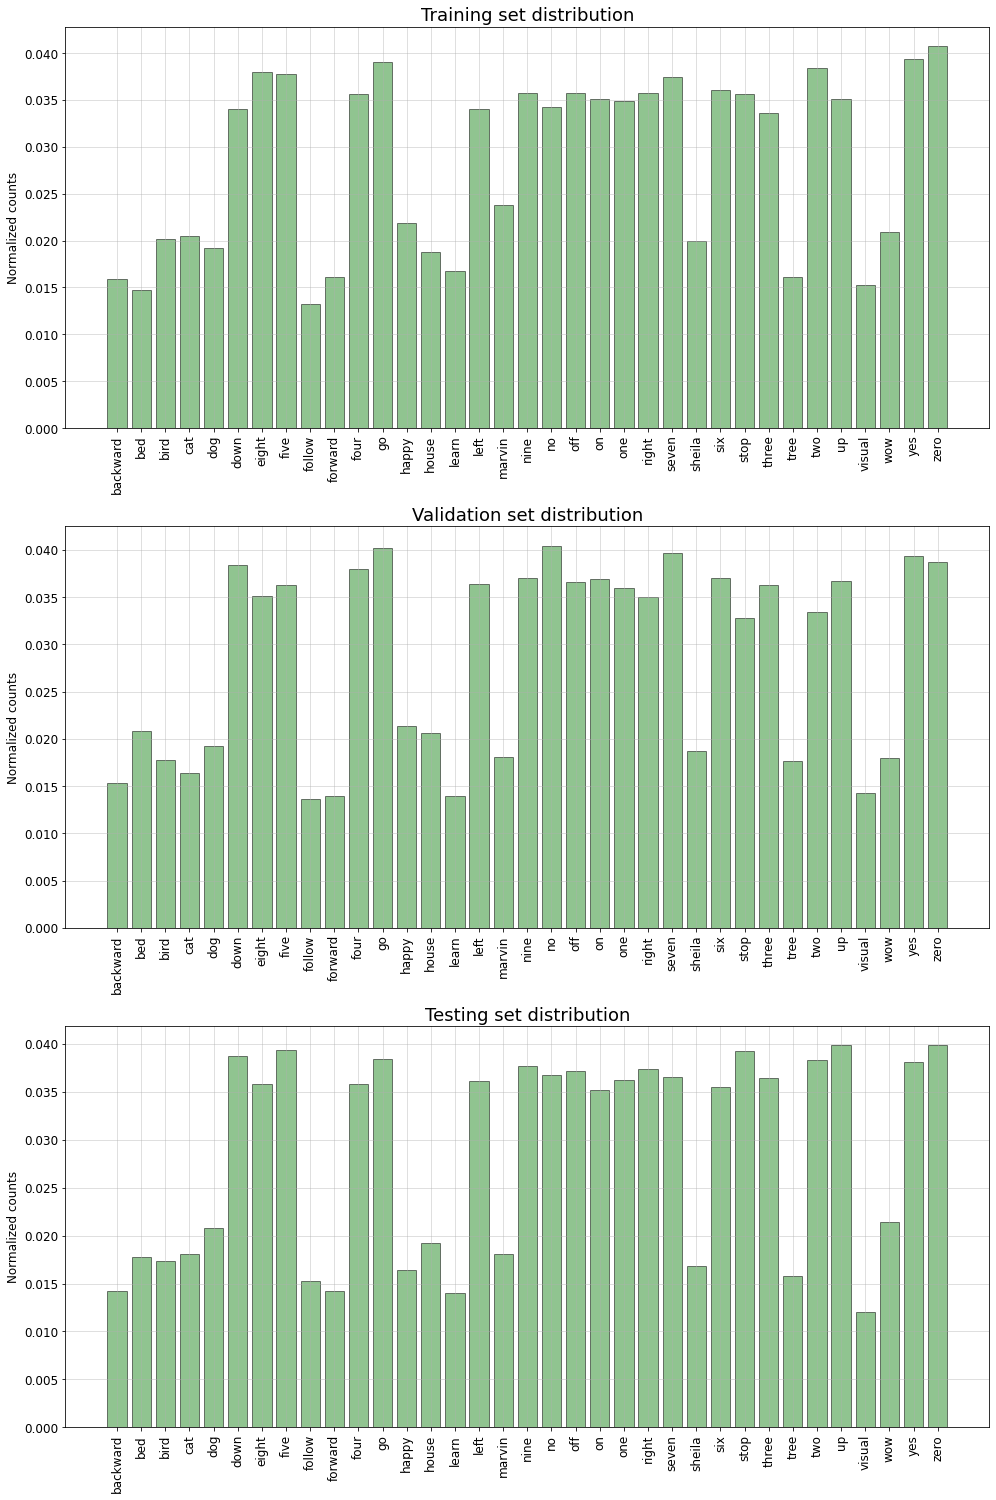

In [12]:
def hist_class_distribution(set_x, ax):
    frequencies = []
    
    for command in commands:
        frequencies.append(set_x[set_x.label==command].shape[0])
        
    frequencies = np.array(frequencies)/len(set_x)
    
    ax.bar(commands, frequencies, edgecolor='black', alpha=0.5, color='forestgreen')
    
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

hist_class_distribution(reference_df_train, ax[0])
hist_class_distribution(reference_df_val, ax[1])
hist_class_distribution(reference_df_test, ax[2])

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.5 - Load data
Now we define a function to load the actual audio signals from the files. As data is stored as .wav files, we can load it using the  `wavfile.read` function from the scipy library ([doc here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html)). 

The function takes in input the path of the file to be loaded, that can be obtained from the filename *file_name* (.wav) and the corresponding label *file_label* as:
```python
    file_path = data_path + '/' + file_label + '/' + file_name
```
Then, `wavfile.read(file_path)` returns a tuple of two items: the first is the sampling rate in samples per second, the second is a numpy array with all the data read from the file. As this dataset only contains single channel audio, after getting the data we use the `np.squeeze` function to drop the extra axis.

We show an example for the label _yes_ and one for the label _no_.

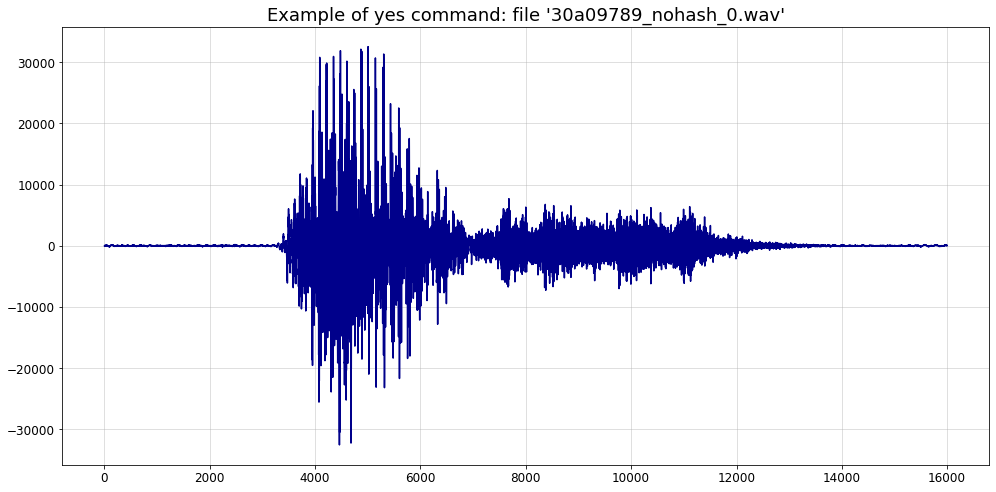

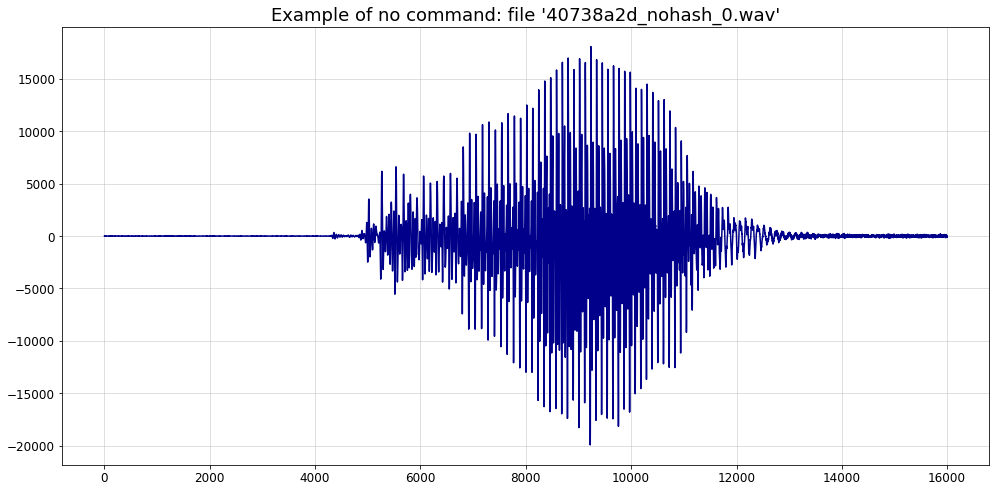

In [13]:
def load_data(file_name, file_label, data_path_=data_path):
    if isinstance(file_name, bytes):
        file_name = file_name.decode()
    if isinstance(file_label, bytes):
        file_label = file_label.decode()
    if isinstance(data_path_, bytes):
        data_path_ = data_path_.decode()

    if not isinstance(file_label, str):
        file_label = class_to_label[file_label]

    file_path = data_path_ + '/' + file_label + '/' + file_name
    _, data = wavfile.read(file_path)

    return data.squeeze()

# Examples

# Plot a 'yes' command from training set
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yes_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of yes command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

# Plot a 'no' command from training set
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(no_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of no command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

### 1.6 - Preprocessing: trimming and padding
Let's print the shape of some training data to see if they are all equal or there are some variations. 

In [14]:
for i in range(50):
    data = load_data(reference_df_train.iloc[i].file, reference_df_train.iloc[i].label)
    print('File: {} - Shape: {}'.format(reference_df_train.iloc[i].file, data.shape))

File: 3bb68054_nohash_0.wav - Shape: (16000,)
File: a1cff772_nohash_2.wav - Shape: (16000,)
File: c634a189_nohash_1.wav - Shape: (16000,)
File: 76424fa5_nohash_0.wav - Shape: (16000,)
File: f4cae173_nohash_1.wav - Shape: (16000,)
File: 9a4d12fd_nohash_0.wav - Shape: (16000,)
File: d0745d72_nohash_0.wav - Shape: (9659,)
File: b31ad508_nohash_0.wav - Shape: (16000,)
File: c392e01d_nohash_0.wav - Shape: (16000,)
File: 4c3cddb8_nohash_2.wav - Shape: (16000,)
File: 10c6d873_nohash_2.wav - Shape: (16000,)
File: fda46b78_nohash_0.wav - Shape: (16000,)
File: 742d6431_nohash_4.wav - Shape: (16000,)
File: c50f55b8_nohash_9.wav - Shape: (16000,)
File: 625fd898_nohash_0.wav - Shape: (15233,)
File: f19c1390_nohash_1.wav - Shape: (16000,)
File: 879a2b38_nohash_3.wav - Shape: (16000,)
File: db72a474_nohash_0.wav - Shape: (16000,)
File: 6565a81d_nohash_3.wav - Shape: (16000,)
File: 13dce503_nohash_0.wav - Shape: (14861,)
File: f2898d06_nohash_0.wav - Shape: (16000,)
File: 10ace7eb_nohash_2.wav - Shape

Notice that the file '0a396ff2_nohash_0.wav' has shape (10922,), meaning that not all audio files have the same shape. The audio clips are 1 second or less at 16kHz, so we need to pad the short ones to exactly 1 second (and eventually trim the longer ones), so that the samples can be processed by the neural network, that requires a fixed input shape. Most of the samples have 16000 samples (1 second at 16kHz sampling frequency), so let's use this value as our fixed input shape.

In the following function, audio files longer than `output_sequence_length=160000` will be truncated to `output_sequence_length`, while audio signals shorter than this are padded to get the same length. The padding is otained using the `np.pad` function with `mode='mean'` ([doc here](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)). More in detail, we pad half on the left (`int(np.ceil(tot_pads / 2))`) and half on the right (`int(np.floor(tot_pads / 2))`).

When truncating the signal, we decided **not** to randomly select a portion of the signal, as we noticed that in this case we typically don't lose any infeormation by simply cropping it to [0, output_sequence_length-1].


File: 3bb68054_nohash_0.wav - Shape: (16000,)


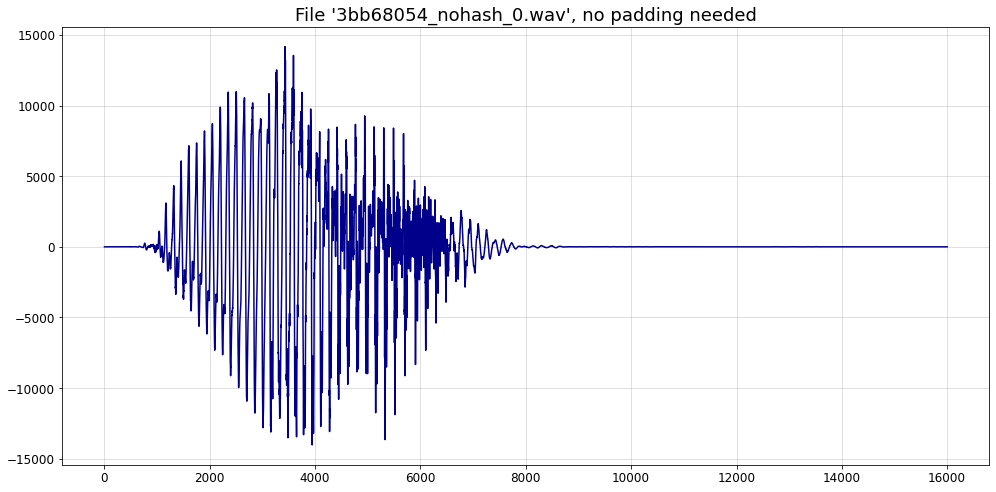

In [15]:
def padding_trimming(data, output_sequence_length=16000):
    data_shape = data.shape[0]
    
    # trimming
    if data_shape>output_sequence_length:
        data=data[:output_sequence_length]
    
    # padding
    elif data_shape<output_sequence_length:
        tot_pad = output_sequence_length-data_shape
        pad_before = int(np.ceil(tot_pad/2))
        pad_after  = int(np.floor(tot_pad/2))
        data = np.pad(data, pad_width=(pad_before, pad_after), mode='mean')
        
    return data

# let's test it on a audio file with correct length
plot_obj = reference_df_train.iloc[0]
data = load_data(plot_obj.file, plot_obj.label)
print('File: {} - Shape: {}'.format(plot_obj.file, data.shape))

data = padding_trimming(data)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("File '{}', no padding needed".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

if not smoke_test:
    # let's test it on 0a396ff2_nohash_0.wav, as we know it needs padding
    plot_obj = reference_df_train[reference_df_train.file=='0a396ff2_nohash_0.wav'].iloc[0]
    data = load_data(plot_obj.file, plot_obj.label)
    print('File: {} - Shape: {}'.format(plot_obj.file, data.shape))

    data_new = padding_trimming(data)
    print('\nAfter padding:')
    print('File: {} - Shape: {}'.format(plot_obj.file, data_new.shape))

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(np.arange((16000-data.shape[0])//2, (16000-data.shape[0])//2+data.shape[0]), data, color='darkblue', label='Original signal', zorder=2)
    ax.plot(data_new, color='red', label='Padding', zorder=1)
    ax.grid(alpha=0.5)
    ax.set_title("File '{}', padding needed".format(plot_obj.file), fontsize=18)
    ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='upper left')

    plt.tight_layout()
    plt.show()

### 1.7 - Background Noise 
To help train machine learning models to cope with noisy environments, it can be helpful to mix in realistic background audio. The `_background_noise_` folder contains a set of longer audio clips that are either recordings or mathematical simulations of noise. They were all either collected personally by Pete Warden in July 2017, or generated in the case of the pink and white noise. For more details, see the `_background_noise_/README.md`.

We define a function to mix one of these background audio signals into an input audio clip. With `select_noise` it is possible to select which of the available background audio clips to use. In particular, the following match is applied:

$1 \longrightarrow $ doing_the_dishes.wav <br>
$2 \longrightarrow $ dude_miaowing.wav <br>
$3 \longrightarrow $ exercise_bike.wav <br>
$4 \longrightarrow $ pink_noise.wav <br>
$5 \longrightarrow $ running_tap.wav <br>
$6 \longrightarrow $ white_noise.wav 

If `select_noise=None` (default value), then the background noise is randomly chosen between the available ones. Moreover, as these clips  still have a 16kHz sample rate but are longer than 1 second, we randomly select a portion of them to match the size of the input.


C:\Users\Nicola\AppData\Local\Temp/ipykernel_20856/2229000366.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


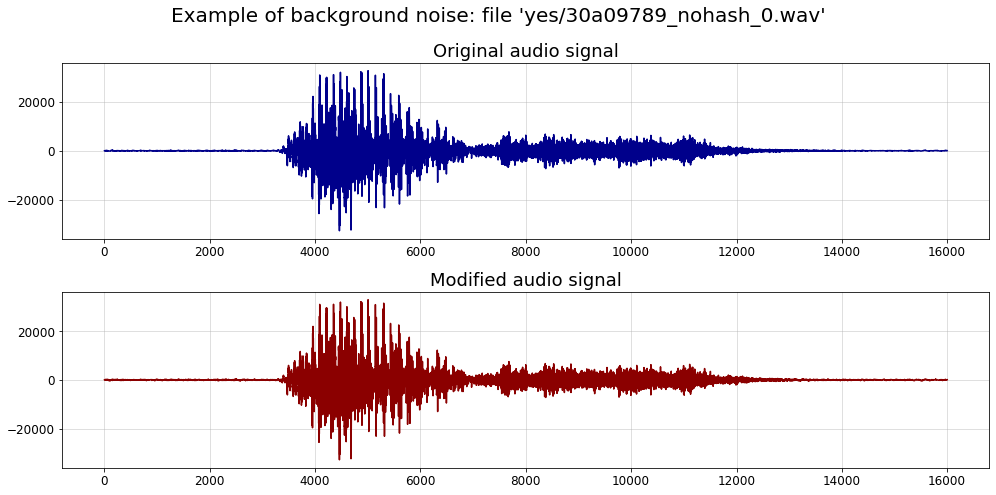

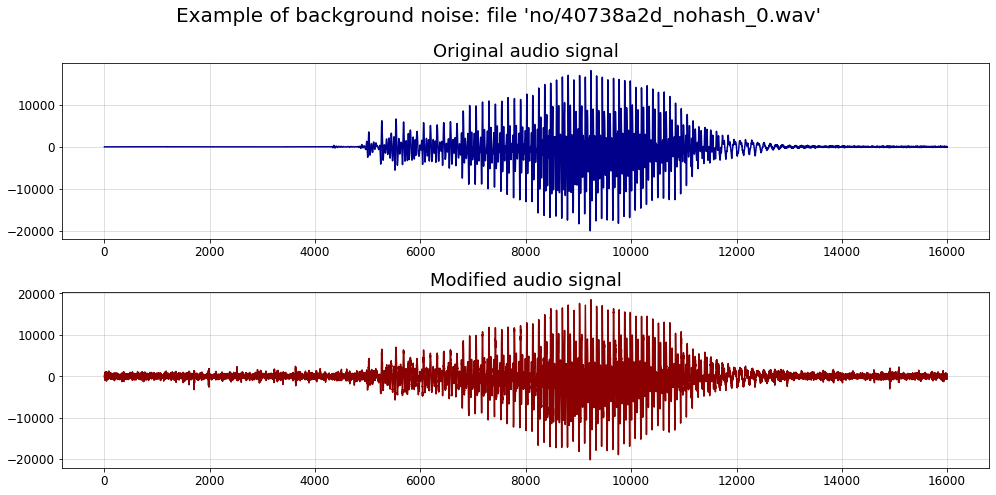

In [16]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = load_data('doing_the_dishes.wav', noise_path)
noise_2 = load_data('dude_miaowing.wav', noise_path)
noise_3 = load_data('exercise_bike.wav', noise_path)
noise_4 = load_data('pink_noise.wav', noise_path)
noise_5 = load_data('running_tap.wav', noise_path)
noise_6 = load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

def background_noise(data, select_noise=None, noise_reduction=0.8):
    '''
    data: input audio signal, already loaded and preprocessed, it must be a numpy array 
    select_noise: decide what kind of noise to add to the input signal, by default a random choice 
    noise_reduction: set it to a value between 0 and 1 to reduce the amount of noise, by default 0.8
    '''
    
    target_size = data.shape[0]
    
    # None case
    if select_noise is None:
        select_noise = np.random.choice(np.arange(1, 7))
        
    # other cases, plus random selection  
    noise_data = noise_dict[str(select_noise)]
    N = noise_data.shape[0]
    
    # random cropping
    from_ = np.random.randint(0, int(N-target_size))
    to_ = from_ + target_size
    noise_data = noise_data[from_:to_]
    
    # add noise to input audio
    data_with_noise = data + (1-noise_reduction)*noise_data
    
    return data_with_noise
        
# Let's test it on the same examples we used before
np.random.seed(22)

# 'yes' command from training set, with 'doing_the_dishes.wav' background noise
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = load_data(plot_obj.file, plot_obj.label)

yes_data_wn = background_noise(yes_data, select_noise=1)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(yes_data, color='darkblue')
ax[1].plot(yes_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'yes/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

# 'no' command from training set, with random background noise
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = load_data(plot_obj.file, plot_obj.label)

no_data_wn = background_noise(no_data)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(no_data, color='darkblue')
ax[1].plot(no_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'no/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

Let's play these audio signals.  

In [17]:
# Audio(yes_data, rate=16000)

# Audio(yes_data_wn, rate=16000)

# Audio(no_data, rate=16000)

# Audio(no_data_wn, rate=16000)

### 1.8 - Extract features

#### 1.8.1 - Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, we'll transform the waveforms from the time-domain signals into the frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. We will feed the spectrogram images into our neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor on which standard convolutions can be runned.

Let's create a utility function for converting waveforms to spectrograms:

- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, we'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [18]:
def get_spectrogram(waveform):

    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform.astype(float), frame_length=255, frame_step=128)

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution layers (which expect shape (`batch_size`, `height`, `width`, `channels`)).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

Now, define a function for displaying a spectrogram:

In [19]:
def plot_spectrogram(spectrogram, ax):
  
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot an sample waveform over time and the corresponding spectrogram (frequencies over time):

Spectrogram shape: (124, 129, 1)


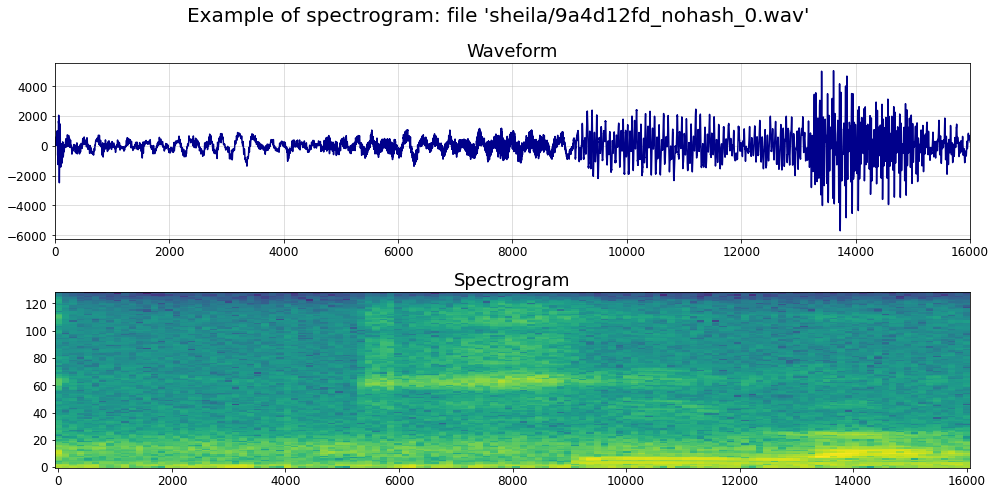

In [20]:
plot_obj = reference_df_train.iloc[5]
waveform = load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(2, figsize=(14, 7))
timescale = np.arange(waveform.shape[0])
ax[0].plot(timescale, waveform, color='darkblue')
ax[0].set_title('Waveform', fontsize=18)
ax[0].set_xlim([0, 16000])
ax[0].grid(alpha=0.5)

spectrogram = get_spectrogram(waveform)
print('Spectrogram shape:', spectrogram.shape)

plot_spectrogram(spectrogram.numpy(), ax[1])
ax[1].set_title('Spectrogram', fontsize=18)

plt.suptitle("Example of spectrogram: file '%s/{}'".format(plot_obj.file) %(plot_obj.label), fontsize=20)
plt.tight_layout()
plt.show()

Examine the spectrograms for different examples of the dataset:

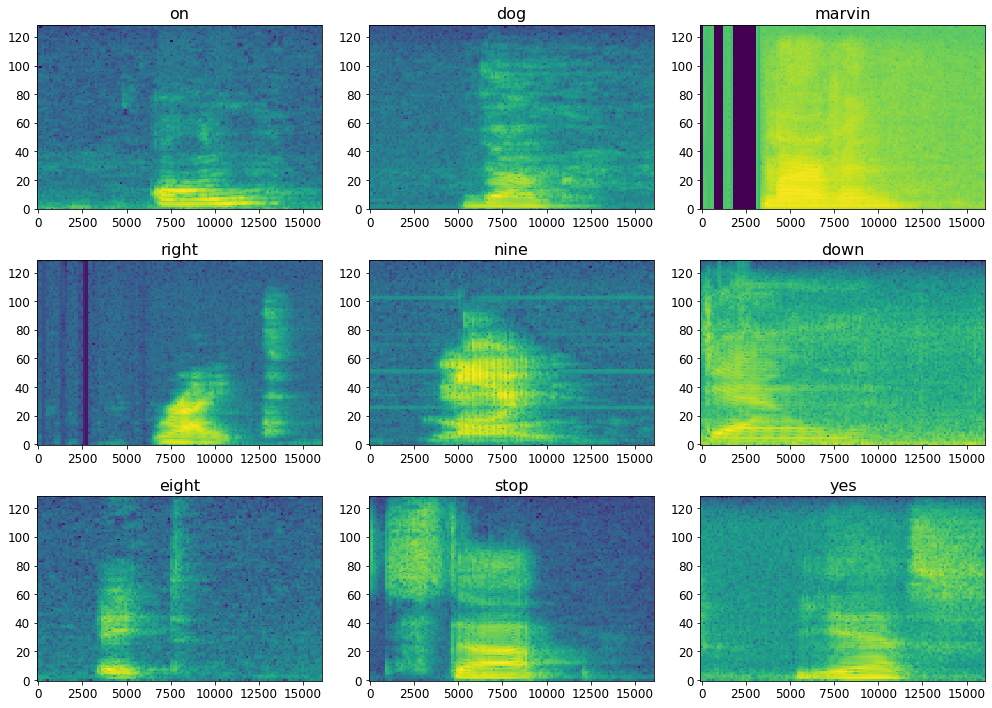

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 10))

np.random.seed(22)
for i in range(n):
    
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_obj = reference_df_train.sample().squeeze()
    waveform = load_data(plot_obj.file, plot_obj.label)
    spectrogram = get_spectrogram(waveform)

    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(plot_obj.label, fontsize=16)

plt.tight_layout()
plt.show()

#### 1.8.2 - MFCC features
Reference: [A Step-by-Step Guide to Speech Recognition and Audio Signal Processing in Python | Towards Data Science](https://towardsdatascience.com/a-step-by-step-guide-to-speech-recognition-and-audio-signal-processing-in-python-136e37236c24) 

MFCC is a technique designed to extract features from an audio signal. It uses the MEL scale to divide the audio signal’s frequency bands and then extracts coefficients from each individual frequency band, thus, creating a separation between frequencies. MFCC uses the Discrete Cosine Transform (DCT) to perform this operation. The MEL scale is established on the human perception of sound, i.e., how the human brain process audio signals and differentiates between the varied frequencies.

In [22]:
from python_speech_features import mfcc, delta

def get_mfcc(
            signal,                    # audio signal from which to compute features (N*1 array)
            samplerate   = 16000,      # samplerate of the signal we are working with
            winlen       = 25,         # length of the analysis window (milliseconds)
            winstep      = 10,         # step between successive windows (milliseconds)
            numcep       = 13,         # number of cepstrum to return
            nfilt        = 26,         # number of filters in the filterbank
            nfft         = 512,        # FFT size
            lowfreq      = 300,        # lowest band edge of mel filters (Hz)
            highfreq     = None,       # highest band edge of mel filters (Hz)
            appendEnergy = True,       # if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy
            winfunc      = np.hamming, # analysis window to apply to each frame
            delta_order  = 2,          # maximum order of the Delta features
            delta_window = 1           # window size for the Delta features
            ):

    if highfreq is None:
        highfreq = samplerate / 2

    features = []

    # Extract MFCC features
    mfcc_feat = mfcc(
                signal,
                samplerate,
                winlen/1000,
                winstep/1000,
                numcep,
                nfilt,
                nfft,
                lowfreq,
                highfreq,
                appendEnergy=appendEnergy,
                winfunc=winfunc                
                )
    mfcc_feat = mfcc_feat.T
    features.append(mfcc_feat)

    # Extract Delta features
    for i in range(delta_order):

        features.append(delta(features[-1], delta_window))

    # Full feature vector
    full_feat = np.vstack(features)

    return full_feat

Now, define a function for plotting the MFCC features:

In [23]:
def plot_mfcc(features, title=None):

    fig, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(features)
    ax.set_xlabel("Window", fontsize=18)
    ax.set_ylabel("Features", fontsize=18)

    if title is not None:
        ax.set_title(title, fontsize=20)
            
    plt.tight_layout()
    plt.show()

Let's sample a random audio signal from `reference_df_train` and extract features from it.

Full feature vector shape: (39, 99)


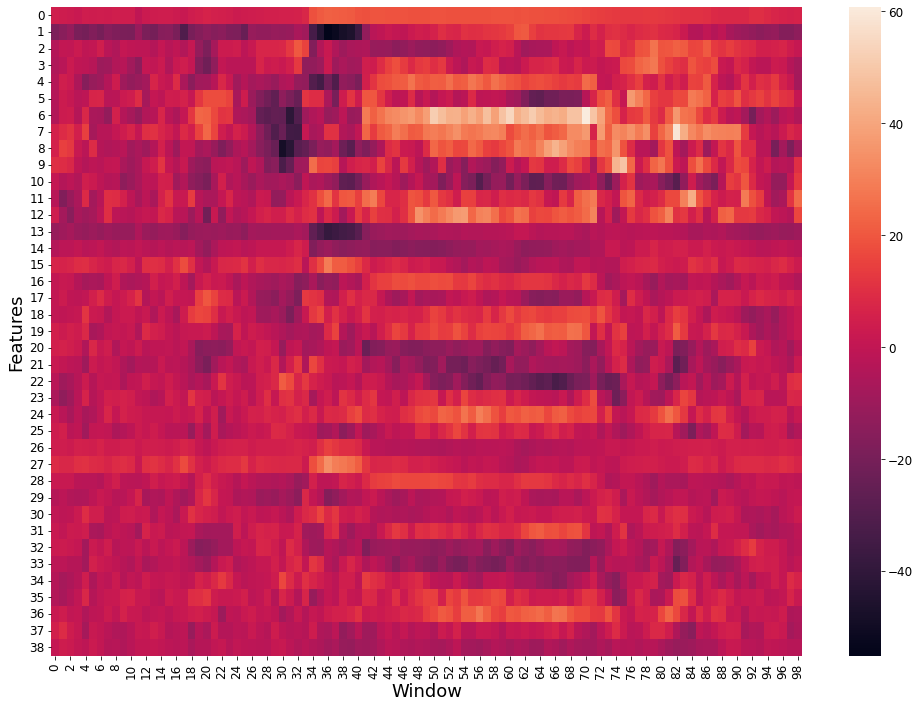

In [24]:
plot_obj = reference_df_train.sample().squeeze()
signal = load_data(plot_obj.file, plot_obj.label)

features = get_mfcc(signal)
print("Full feature vector shape:", features.shape)
plot_mfcc(features)

## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. First, we put together the loading and preprocessing methods in a single function `load_and_preprocess_data`.

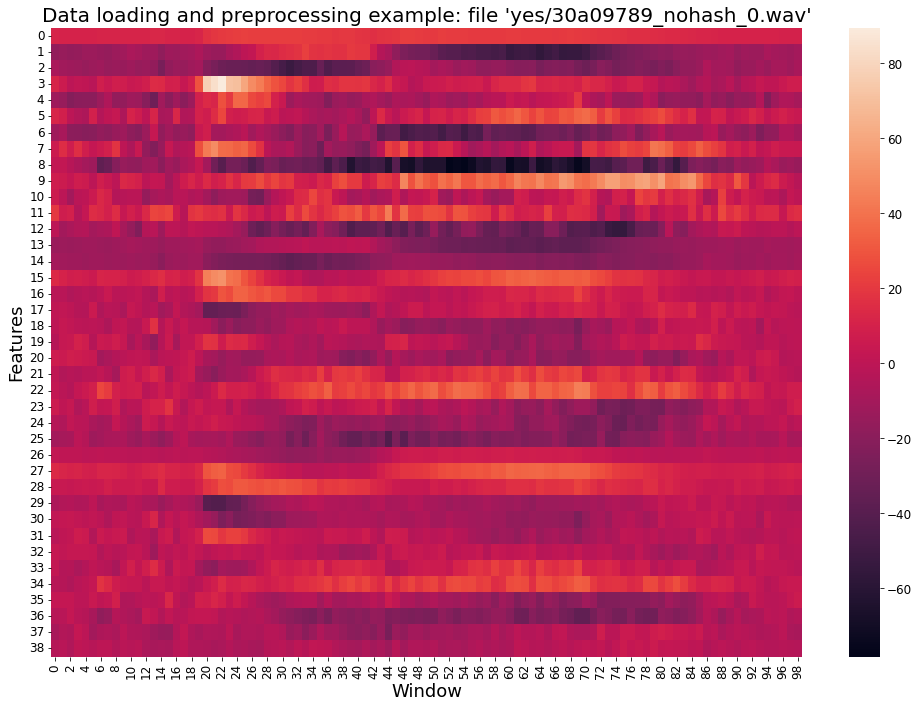

In [25]:
def load_and_preprocess_data(file_name, file_label, data_path_=data_path, apply_background_noise=False, features=1):
    '''
    features:
    - 1 for MFCC (default)
    - 2 for spectrogram
    '''
    
    # load data
    data = load_data(file_name, file_label, data_path_=data_path)
    
    # padding/trimming
    data = padding_trimming(data)
    
    # add background noise
    if apply_background_noise:
        data = background_noise(data)
        
    # extract features
    if features==1:
        data_features = get_mfcc(data)
    
    elif features==2:
        data_features = get_spectrogram(data).numpy()
      
    else:
        raise Exception("'features' must be 1 or 2")
    
    # TensorFlow takes as input 32-bit floating point data
    return data_features.astype(np.float32) 

# Example using MFCC
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
plot_data = load_and_preprocess_data(plot_obj.file, plot_obj.label, apply_background_noise=False, features=1)

plot_mfcc(plot_data, title="Data loading and preprocessing example: file '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# fig, ax = plt.subplots(figsize=(14, 7))
# plot_spectrogram(plot_data, ax)

# plt.tight_layout()
# plt.show()

### 2.1 - Dataset definition
We now define the `create_dataset` function, which initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [26]:
def create_dataset(reference_df, batch_size, shuffle, cache_file=None, apply_background_noise=False, features=1):
    # Convert dataframe to lists
    file_names = reference_df['file']
    labels = reference_df['class']

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (
        tf.numpy_function(
            lambda x, y: load_and_preprocess_data(x, y, apply_background_noise=apply_background_noise, features=features), 
            [file_name, label], 
            tf.float32
        ), label
    )

    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### 2.2 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).


In [27]:
batch_size = 32
features_to_extract = 1
apply_bn = False

train_dataset = create_dataset(
    reference_df_train, 
    batch_size=batch_size, 
    shuffle=True,
    cache_file='train_cache',
    apply_background_noise=apply_bn, 
    features=features_to_extract
)

val_dataset = create_dataset(
    reference_df_val, 
    batch_size=batch_size, 
    shuffle=True,
    cache_file='val_cache',
    apply_background_noise=apply_bn, 
    features=features_to_extract
)

test_dataset = create_dataset(
    reference_df_test, 
    batch_size=batch_size, 
    shuffle=True,
    cache_file='test_cache',
    apply_background_noise=apply_bn, 
    features=features_to_extract
)

train_steps = int(np.ceil(len(reference_df_train)/batch_size))
val_steps = int(np.ceil(len(reference_df_val)/batch_size))
test_steps = int(np.ceil(len(reference_df_test)/batch_size))

## 3 - Models

### 3.1 - Import model
Here we select one of the available network architectures in the file `models_utils.py`.

In [28]:
############### Sainath15 notation ###############
t = 99 # input feature dimension in time
f = 39 # input feature dimension in frequency

# 1st CONV layer
m = 20 # filter size in time
r = 8  # filter size in frequency
s = 1  # stride in time
v = 1  # stride in frequency
p = 1  # max-pooling in time
q = 3  # max-pooling in frequency
##################################################

In [29]:
from models_utils import smallCnnModel

input_shape = (99, 39)

model = smallCnnModel(input_shape)
model_name = smallCnnModel.__name__

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])


In [30]:
model.summary()

Model: "smallCnnModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 99, 39, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 39, 32)        352       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 39, 64)        10304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 9, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 9, 64)         256       
_________________________________________________________________
dropout (Dropout)            (None, 99, 9, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 9, 64)       

In [31]:
# Show the structure of the model through building blocks
# tf.keras.utils.plot_model(model, to_file=f'{model_name}.png')
# Image(f'{model_name}.png')



## 4 - Model training and testing

### 4.1 - Model training
At this point we can train the model for some epochs.

In [32]:
num_epochs = 10

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint], 
                verbose=1
                )

Epoch 1/10
200/200 [==============================] - 145s 725ms/step - loss: 3.3516 - sparse_categorical_accuracy: 0.1230 - val_loss: 2.8581 - val_sparse_categorical_accuracy: 0.2245
Epoch 2/10
200/200 [==============================] - 123s 615ms/step - loss: 2.5275 - sparse_categorical_accuracy: 0.3025 - val_loss: 2.0814 - val_sparse_categorical_accuracy: 0.4116
Epoch 3/10
200/200 [==============================] - 128s 642ms/step - loss: 1.9745 - sparse_categorical_accuracy: 0.4361 - val_loss: 1.6164 - val_sparse_categorical_accuracy: 0.5398
Epoch 4/10
200/200 [==============================] - 124s 619ms/step - loss: 1.6090 - sparse_categorical_accuracy: 0.5362 - val_loss: 1.3530 - val_sparse_categorical_accuracy: 0.6137
Epoch 5/10
200/200 [==============================] - 126s 629ms/step - loss: 1.3955 - sparse_categorical_accuracy: 0.5928 - val_loss: 1.2512 - val_sparse_categorical_accuracy: 0.6373
Epoch 6/10
200/200 [==============================] - 121s 605ms/step - loss: 1.

In [33]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,3.351591,0.122969,2.858135,0.224531
1,2.527468,0.302500,2.081427,0.411563
2,1.974513,0.436094,1.616357,0.539844
3,1.609005,0.536250,1.353036,0.613750
4,1.395549,0.592812,1.251207,0.637344
5,1.236642,0.632656,1.138235,0.666406
6,1.114786,0.663750,1.121308,0.672188
7,1.000201,0.695156,1.028835,0.701563
8,0.927824,0.717188,1.062812,0.691562
9,0.856273,0.743906,1.135931,0.672500


In [34]:
def plot_history(history):

    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # Plot loss
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='validation')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot accuracy
    ax[1].plot(history.history['sparse_categorical_accuracy'], label='train')
    ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

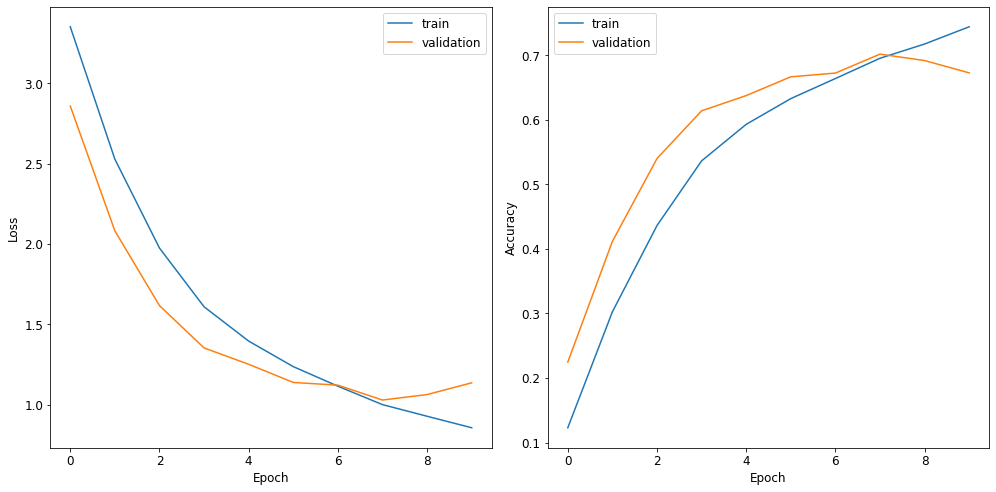

In [35]:
plot_history(history)

Uncomment the cell below to load some pretrained models.

In [36]:
# model = tf.keras.models.load_model('model.h5')
# model.summary()

### 4.2 - Validation metrics
Since the dataset is unbalanced (see histograms in section 1.4) and we have more than 2 classes, the accuracy is not a good metric. To have a good understanding of the classifier performance we must rely on other metrics.  

First we compute the output of the network for all data in the test set. To obtain it use:
```python 
    model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()
```
This is needed because the elements in `[len(val_labels):]` are not part of the dataset, but they are just added to complete the batch. 

Then we get the predicted label by computing the $argmax$ over the output of the network, for each input data. This is motivated by the fact that there are as many neurons as labels in the last layer of the network and we used the softmax activation function. 

In [37]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

Then, to visualize the performance of the algorithm we plot the confusion matrix:

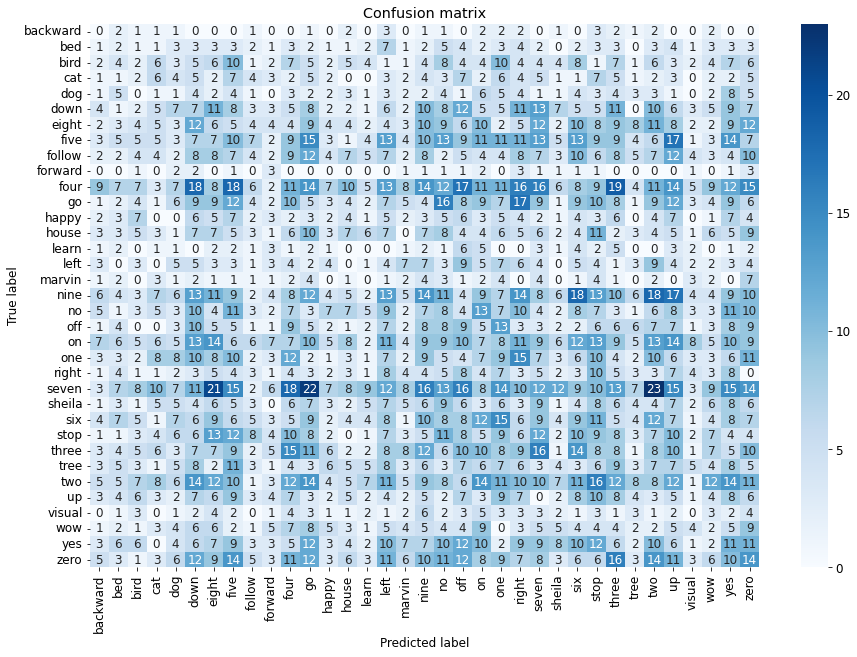

In [38]:
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(cm, annot=True, xticklabels=commands, yticklabels=commands, cmap='Blues')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion matrix')
plt.show()

Moreover, we can evaluate the _precision_, _recall_ and _fscore_ metrics using some methods from the *scikit-learn* library. These metrics are calculated for each class in the dataset, so to get an a high-level view of how our model is performing we need to aggregate them. This can be done in 3 main ways:

1. **Macro average**: it is the unweighted average of the selected metric; it does not take label unbalance into account.
2. **Micro average**: it is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average; in other words it calculates the metrics globally by counting the total TP, FP and FN.
3. **Weighed average**: it is the average of the metric values for individual classes weighted by the support (i.e. the number of true istances) of that class. It alters _macro_ to account for label imbalance.


In [41]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
print('Accuracy:  {:.2f}%'.format(accuracy*100))

def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted], 
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

display(class_report(y_true, y_pred).round(4))


Accuracy:  3.19%


,precision,recall,f1-score
macro,0.0308,0.0292,0.0287
micro,0.0319,0.0319,0.0319
weighted,0.0330,0.0319,0.0315


# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.
